In [32]:
import cv2
import numpy as np
from math import sqrt, floor, ceil, nan, pi
from skimage import color, exposure
from skimage.color import rgb2gray
from skimage.feature import blob_log
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.transform import rotate
from skimage import morphology
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import rgb2hsv
from scipy.stats import circmean, circvar, circstd
from statistics import variance, stdev
from scipy.spatial import ConvexHull


## 1. measure_blue_veil


In [ ]:
#It goes through every pixel in the image and increases a counter if the pixel 
# satisfies a specific color condition that can be interpreted as having a "blue veil" characteristic.

def measure_blue_veil(image):
    
    height, width, _ = image.shape #no. of pixels in height and width
    count = 0

    for y in range(height):
        for x in range(width): #Iterating through every pixel of the picture
            b, g, r = image[y, x] #Extracts the Blue, Green, and Red channel values at each pixel.

            if b > 60 and (r - 46 < g) and (g < r + 15): #extracts a specific condition for a 'blue veil'
                count += 1 #if satisfied counter +=1

    return count

#This function estimates how much of an image is covered by a "blue veil" by counting bluish pixels 
# with specific RGB relationships. It could be used in medical image analysis, 
# especially for identifying potential melanoma features in skin lesion images. ~ chat gpt

In [ ]:
image = cv2.imread(r'C:\Users\filip\Dokumenty\Data Science 2nd semester\Project\data pieprzyki i wlosy\img_1185.png')
count = measure_blue_veil(image)
measure_blue_veil(image)


51.61675347222222

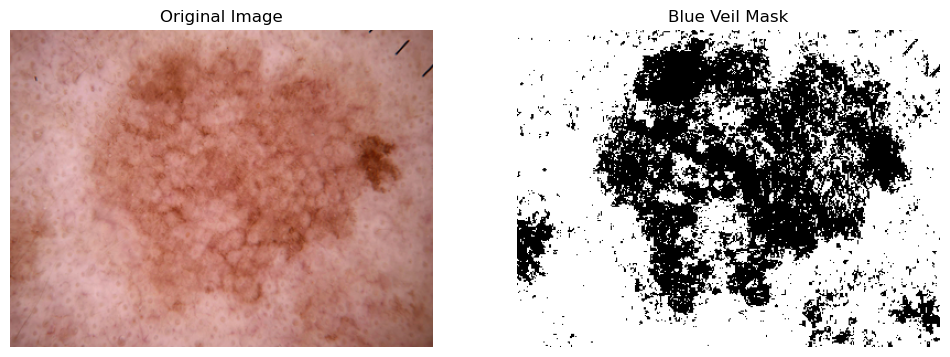

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_blue_veil(image):
    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)  # Empty mask

    for y in range(height):
        for x in range(width):
            b, g, r = image[y, x]

            if b > 60 and (r - 46 < g) and (g < r + 15):
                mask[y, x] = 255  # White pixel if condition met

    return mask



image = cv2.imread('img_0000.png')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

# Get the blue veil mask
mask = visualize_blue_veil(image)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blue Veil Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()

## 2. measure_resgression

In [ ]:
def measure_regression(image):
   
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Converts the input image from BGR (OpenCV’s default) to HSV (Hue, Saturation, Value) 
                                                     #color space. For HSV it's easier to isolate colors by hue and intensity.                                   
    lower_color = np.array([0, 0, 150])
    upper_color = np.array([180, 30, 255]) #This defines the range of HSV values that represent the target color
                                            # Hue (0-180) full range hue, Saturation (0-30) - low, grayish/white colors, 
                                            # Value (150-255) - hight brightness, light/bright pixels
                                            
    mask = cv2.inRange(hsv_img, lower_color, upper_color) #Creates a binary mask where pixels within the specified
                                                        #HSV range are white (255), and all others are black (0)
                                                        #This isolates the regions in the image that match the target color.
    num_pixels = cv2.countNonZero(mask)
                                                        #Counts the number of white pixels in the mask — i.e.,
                                                        # how many pixels matched the regression-like color range.

    return num_pixels                                   #returns number of white pixels


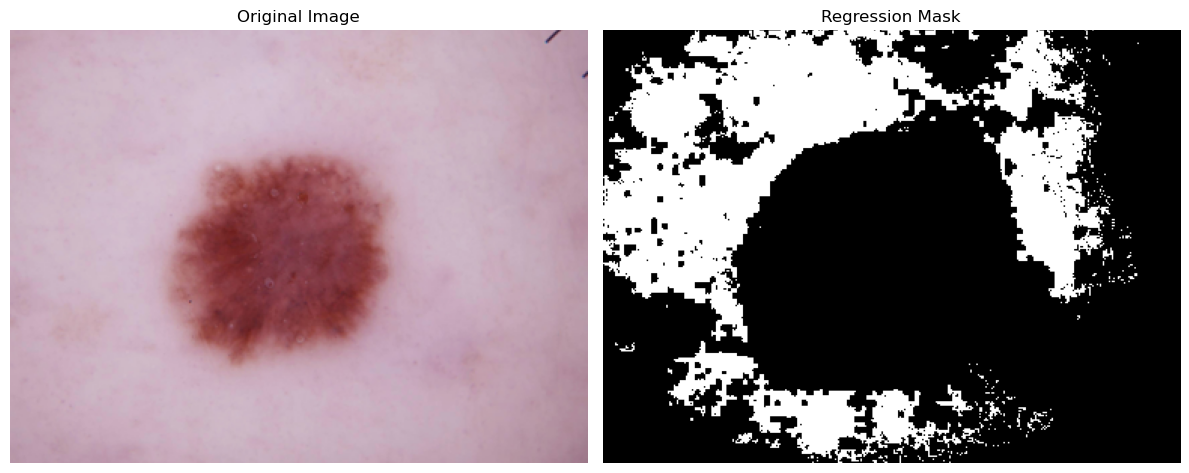

32696

In [24]:
import matplotlib.pyplot as plt
def measure_regression(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_color = np.array([0, 0, 150])
    upper_color = np.array([180, 30, 255])
    mask = cv2.inRange(hsv_img, lower_color, upper_color)
    num_pixels = cv2.countNonZero(mask)

    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Regression Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return num_pixels

image = cv2.imread('img_0001.png')
measure_regression(image)


In [ ]:
def get_multicolor_rate(im, mask, n):
    # mask = color.rgb2gray(mask)
    im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
    mask = resize(
        mask, (mask.shape[0] // 4, mask.shape[1] // 4), anti_aliasing=True
    ) #Both the image and mask are resized to 1/4 of their original size. This improves speed and reduces noise without much loss of detail.
    im2 = im.copy()
    im2[mask == 0] = 0 #Makes a copy of the image. Sets all pixels outside the masked area to black ([0, 0, 0]). This isolates the area of interest.

    columns = im.shape[0]
    rows = im.shape[1]
    col_list = []
    for i in range(columns):
        for j in range(rows):
            if mask[i][j] != 0:
                col_list.append(im2[i][j] * 256) #looping through every pixel of the image. 
                                                  #For pixels inside the mask, their RGB value is multiplied by 256 and added to col_list

    if len(col_list) == 0:
        return ""

    cluster = KMeans(n_clusters=n, n_init=10).fit(col_list)
    com_col_list = get_com_col(cluster, cluster.cluster_centers_)

    dist_list = []
    m = len(com_col_list)

    if m <= 1:
        return ""

    for i in range(0, m - 1):
        j = i + 1
        col_1 = com_col_list[i]
        col_2 = com_col_list[j]
        dist_list.append(
            np.sqrt(
                (col_1[0] - col_2[0]) ** 2
                + (col_1[1] - col_2[1]) ** 2
                + (col_1[2] - col_2[2]) ** 2
            )
        )
    return np.max(dist_list)

## 4. find_midpoint_v1

In [ ]:
def find_midpoint_v1(image):
    
    row_mid = image.shape[0] / 2
    col_mid = image.shape[1] / 2
    return row_mid, col_mid       #returns middle point of an image in a tuple with two floats



image = cv2.imread('img_0001.png')
find_midpoint_v1(image)

(144.0, 192.0)

## 5. Best Asymmetry

In [ ]:
def best_asymmetry(mask, rotations = 30):
    
    asymmetry_scores = rotation_asymmetry(mask, rotations)
    best_score = min(asymmetry_scores.values())

    return best_score

## 6. hsv_var

In [ ]:
def hsv_var(image, slic_segments):
    
    if len(np.unique(slic_segments)) == 2: 
        return 0, 0, 0                 #special case, just two colors 

    hsv_means = get_hsv_means(image, slic_segments)  # getting the hsv means for all segments
    n = len(hsv_means) 

    hue = []
    sat = []
    val = []
    for hsv_mean in hsv_means:
        hue.append(hsv_mean[0])
        sat.append(hsv_mean[1])
        val.append(hsv_mean[2]) #Separate the Hue, Saturation, and Value components into 3 separate lists and appending

    hue_var = circvar(hue, high=1, low=0)
    sat_var = variance(sat, sum(sat)/n)
    val_var = variance(val, sum(val)/n)
    
    #Calculate the variance for each component
    #Hue: use circular variance (circvar), again because hue wraps around (0 ≈ 360 degrees).
    # Saturation and Value: standard variance.
    # Here variance(x, mean_of_x) means they probably use a function that needs the mean provided.

    return hue_var, sat_var, val_var #in the end I'll get how hue, saturation and brightness vary across the pic
# hue var ranges from 0 to 1, rest from 0 to 0.25

In [ ]:
image = cv2.imread('img_0000.png')
slic_segments = slic(image, n_segments=50, compactness=10, start_label=1) #n = 50 segments, 
                                                    #compactness - lower is focus on color, higher makes segments as square as possible, 
                                                    # starting labels from 1 to 50 in this case
hue_variance, saturation_variance, value_variance = hsv_var(image, slic_segments)
print(hue_variance, saturation_variance, value_variance)

0.0013628410559264337 0.012110350096370587 0.005231269367090853


### Not mine, but needed

In [ ]:
# second level 


def cut_mask(mask):
    
    col_sums = np.sum(mask, axis=0)
    row_sums = np.sum(mask, axis=1)

    active_cols = []
    for index, col_sum in enumerate(col_sums):
        if col_sum != 0:
            active_cols.append(index)

    active_rows = []
    for index, row_sum in enumerate(row_sums):
        if row_sum != 0:
            active_rows.append(index)

    col_min = active_cols[0]
    col_max = active_cols[-1]
    row_min = active_rows[0]
    row_max = active_rows[-1]

    cut_mask_ = mask[row_min:row_max+1, col_min:col_max+1]

    return cut_mask_




def asymmetry(mask):
    

    row_mid, col_mid = find_midpoint_v1(mask)

    upper_half = mask[:ceil(row_mid), :]
    lower_half = mask[floor(row_mid):, :]
    left_half = mask[:, :ceil(col_mid)]
    right_half = mask[:, floor(col_mid):]

    flipped_lower = np.flip(lower_half, axis=0)
    flipped_right = np.flip(right_half, axis=1)

    hori_xor_area = np.logical_xor(upper_half, flipped_lower)
    vert_xor_area = np.logical_xor(left_half, flipped_right)

    total_pxls = np.sum(mask)
    hori_asymmetry_pxls = np.sum(hori_xor_area)
    vert_asymmetry_pxls = np.sum(vert_xor_area)

    asymmetry_score = (hori_asymmetry_pxls + vert_asymmetry_pxls) / (total_pxls * 2)

    return round(asymmetry_score, 4)

In [ ]:
#first level



def get_hsv_means(image, slic_segments):
    
    hsv_image = rgb2hsv(image)  #convert RGB image to HSV color space

    max_segment_id = np.unique(slic_segments)[-1] #find the highest segment label

    hsv_means = []   #empty list for means 
    for i in range(1, max_segment_id + 1): #looping through all id_segments

        segment = hsv_image.copy()
        segment[slic_segments != i] = nan #it's done to consider only current segment (some sort of a mask)

        hue_mean = circmean(segment[:, :, 0], high=1, low=0, nan_policy='omit') 
        sat_mean = np.mean(segment[:, :, 1], where = (slic_segments == i))  
        val_mean = np.mean(segment[:, :, 2], where = (slic_segments == i)) #calculate mean hue, saturation, and value

        hsv_mean = np.asarray([hue_mean, sat_mean, val_mean]) #taking means into an array

        hsv_means.append(hsv_mean) #appending to our empty list 
        
    return hsv_means



def get_com_col(cluster, centroids):
    com_col_list = []
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins=labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)], key= lambda x:x[0])
    start = 0
    for percent, color in colors:
        if percent > 0.08:
            com_col_list.append(color)
        end = start + (percent * 300)
        cv2.rectangle(
            rect,
            (int(start), 0),
            (int(end), 50),
            color.astype("uint8").tolist(),
            -1,
        )
        start = end
    return com_col_list



def rotation_asymmetry(mask, n: int):

    asymmetry_scores = {}

    for i in range(n):

        degrees = 90 * i / n

        rotated_mask = rotate(mask, degrees)
        cutted_mask = cut_mask(rotated_mask)

        asymmetry_scores[degrees] = asymmetry(cutted_mask)

    return asymmetry_scores

